# Overview
In this notebook, we will classify movie reviews as *positive* or *negative* using the text of the review. It would be an example of binary or two-class classification, an important and widely applicable kind of ML problem. <br>
We will be using the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Databse. We will use 25,000 reviews as training data and the rest 25,000 as the testing data. Both sets contain equal number of negative and positive reviews.

# Updating to TensorFlow 2.0 Alpha

In [1]:
from __future__ import absolute_import, division, print_function

!pip install -q tensorflow==2.0.0-alpha0

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.0.0-alpha0


# Downloading the IMDB Dataset
The IMDB dataset comes packaged with TensorFlow. It has already preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary. <br>
The argument `num_words=10000` keeps the top 10,000 most frequently occuring words in the training data. The rare words are discarded to keep the size of the data manageable.

In [2]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


# Exploratory Analysis
The dataset, as discussed, comes preprocessed i.e. each example is an array of integers representing the words of the movie review. Each label is an integer value of either 0 or 1, where 0 is *negative* and 1 is *positive* review.

In [3]:
print("Training enteries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training enteries: 25000, labels: 25000


The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Here's what the 69th review looks like

In [4]:
print(train_data[69])

[1, 48, 335, 6, 337, 7, 22, 1359, 5, 104, 36, 92, 97, 4403, 40, 36, 343, 8, 133, 9, 129, 1527, 36, 43, 92, 97, 4403, 11, 363, 1627, 75, 215, 471, 8, 4, 785, 8, 377, 89, 2349, 1302, 5, 1307, 6, 73, 93, 22, 39, 15, 512, 70, 30, 332, 61, 4047, 9, 6, 1669, 1606, 117, 3470, 8, 4, 2737, 39, 167, 6990, 2, 1890, 2455, 2804, 5, 478, 354, 39, 2, 2, 5, 3244, 2, 10, 10, 4, 1121, 114, 100, 28, 77, 398, 11, 4, 7239, 995, 21, 2276, 1233, 2697, 5, 6, 1393, 21, 2, 5203, 6485, 37, 505, 46, 8, 30, 2, 3548, 1974, 257, 85, 137, 581, 456, 7, 3752, 4182, 5, 6626, 8803, 257, 85, 8, 909, 68, 205, 630, 2061, 1315, 119, 784, 649, 3107, 56, 1676, 4090, 1237, 5436, 1405, 6879, 491, 2018, 5, 775, 7, 278, 32, 206, 304, 273, 11, 2279, 6119, 5, 42, 862, 3990, 1979, 10, 10, 2, 47, 3357, 49, 682, 1299, 7, 265, 4, 5203, 6485, 9, 35, 2, 1052, 3504, 37, 571, 8, 30, 754, 5080, 5, 1077, 41, 5484, 886, 1256, 8, 193, 1060, 23, 148, 37, 2, 41, 5, 121, 25, 238, 535, 9147, 119, 139, 25, 1974, 15, 199, 105, 26, 3375, 2094, 5, 5832

Movie reviews are of different lengths as shown by code below. We will have to resolve it later as inputs to a neural network should be equal in length.

In [6]:
len(train_data[0]), len(train_data[1])

(218, 189)

# Converting Integers back to Words
We will create a helper function to query a dictionary object that contains the integer to string mapping.

In [7]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [0]:
#The first indices are reversed
word_index = {k: (v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [0]:
def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

Let's decode the first review to text by using the `decode_review` function.

In [10]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# Data Preparation
The reviews which are in the form of integer arrays must be converted into tensors before feeding them to a neural network. We will use the following method: <br>
We will pad the arrays so they all have the same length, then we'll create an integer tensor of shape `max_length * num_reviews`. We will use an embedding layer capable of handling this shape as the first layer in the network. <br>
We will use `pad_sequences` function to standardize the lengths.

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding='post',
                                                      maxlen=256)

Lengths are now equal

In [12]:
len(train_data[0]), len(train_data[1])

(256, 256)

Inspecting the first 'padded' review.

In [13]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

# Building the Model
The neural network is created by stacking layers. We will have to decide the number of layers and the number of *hidden units* in each layer to build this model.

# Model Summary
Layers are stacked sequentially to build the classifier. <br>
* The first layer is and `Embedding` layer. It takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`. 
* Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
* This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
* The lasst layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

# Hidden Units
The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.
<br>
If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

In [14]:
#input shape is the vocabulary count for the movie reviews
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


# Loss Function & Optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. <br>
This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities ass it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions. <br>
Now let's configure the model to use an optimizer and a loss function.

In [0]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Creating a Validation Set
When training, we have to check the accuracy of the model on data it hasn't seen before. We will create a *validation set* by setting 10,000 examples from the original training data. 

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

# Training the Model
We will train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, we'll monitor the model's loss and accuracy on the 10,000 samples from the validation set.

In [20]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 95us/sample - loss: 0.6921 - accuracy: 0.5471 - val_loss: 0.6904 - val_accuracy: 0.5757
Epoch 2/40
15000/15000 [==============================] - 1s 68us/sample - loss: 0.6868 - accuracy: 0.6337 - val_loss: 0.6832 - val_accuracy: 0.6407
Epoch 3/40
15000/15000 [==============================] - 1s 66us/sample - loss: 0.6756 - accuracy: 0.6979 - val_loss: 0.6694 - val_accuracy: 0.7195
Epoch 4/40
15000/15000 [==============================] - 1s 66us/sample - loss: 0.6561 - accuracy: 0.7277 - val_loss: 0.6471 - val_accuracy: 0.7625
Epoch 5/40
15000/15000 [==============================] - 1s 65us/sample - loss: 0.6272 - accuracy: 0.7740 - val_loss: 0.6168 - val_accuracy: 0.7782
Epoch 6/40
15000/15000 [==============================] - 1s 65us/sample - loss: 0.5889 - accuracy: 0.8057 - val_loss: 0.5787 - val_accuracy: 0.7908
Epoch 7/40
15000/15000 [==============================] 

# Model Evaluation
Now let's see how our model performs. The two values retuened would be *loss* and *accuracy*.

In [21]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 40us/sample - loss: 0.3412 - accuracy: 0.8697
[0.3411881626224518, 0.86968]


This fairly naive approach achieves an accuracy of about 86%. With more advanced approaches, the model should get closer to 95%

# Creating a Graph of Accuracy & Loss over Time
`model.fit()` returns `History` object that contains a dictionary with everything that happened during training.

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We will use these to plot the training and validation loss for comparison, as well as the training and validation accuracy.

In [0]:
import matplotlib.pyplot as plt

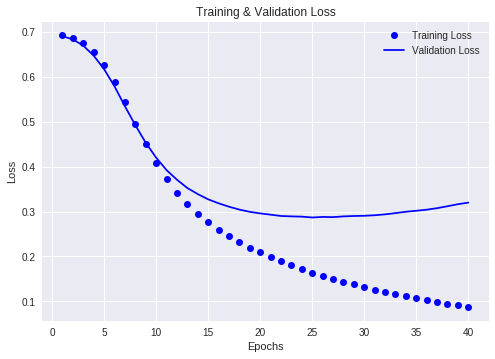

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training Loss') # "bo" == "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation Loss') # "b" == blue solid line
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

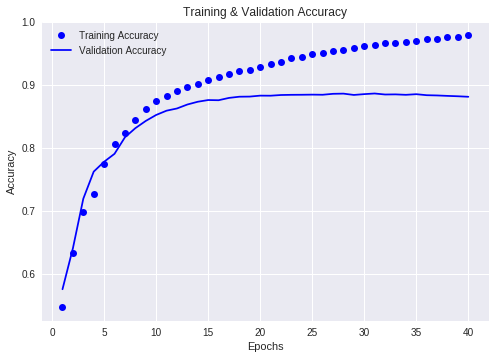

In [25]:
plt.clf() #clears figure

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Interpretations
In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.
<br>
Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.
<br>
This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not *generalize* to test data. For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs.